In [1]:
%reset -f
#########File names with 'H' is actually 'Low'. Changed definition of λ. Before: Frisch=1/λ. Now: Frisch=λ

In [2]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
plt.style.use('classic')
%matplotlib inline

In [3]:
# Model parameters
parameters=pd.Series(dtype='float64')
parameters['β']=0.98 # discount rate : standard
parameters['γ']=2 # risk aversion : standard
parameters['η']=0.83 # Elasticity of substitution (tradable vs nontradable) : conservative (Bianchi,2011)
parameters['ξ']=1.5 # Elasticity of substitution (domestic tradable vs import) : standard 
parameters['σ']=6 # Elasticity of substitution (differentiated varieties) : standard
parameters['ν']=0.047 # bond adjustment cost : target 10% of GDP in ss
#parameters['P_T']=1 # tradable price index (numeraire)
parameters['P_TI']=1# import price index (exogenous numeraire) 
parameters['ω']=0.5 # weight on tradables : target 50% tradable share in consumption (Lombardo and Ravenna, 2012)
#parameters['L']=1 # labor supply

parameters['k']=1/1.67+parameters['σ']-1  # shape parameter of Pareto : target 1.67 log US plant sales sd
parameters['a_min']=1 # lower bound of Pareto

parameters['μ']=0.6 # foreign input share of export fixed cost (Chaney 2016, 0.5~0.7)
parameters['F_x']=0.0034 # export fixed cost : target 21% exporting firms in US
parameters['F_e']=1 # entry cost
parameters['ψ']=0.025 # probability of firm exit : US data, 10 percent job destruction per year)
parameters['κ']=1 # development of financial market (benchmark=1)
parameters['τ']=1.3 # iceberg trade cost : standard (Obstfeld and Rogoff, 2001)

parameters['Ε']=1 # Nominal exchange rate
parameters['P_star']=1 # foreign price index
parameters['w_star']=10 # foreign wage : arbitrary
parameters['W_star']=11 # foreign nominal wage
parameters['r_star']=0.04 # foreign bond return : standard
parameters['A_star']=1 # foreign technology
#parameters['P_T_star']=1 # foreign tradable price index
#parameters['P_TI_star']=5 # foreign imported tradable price index
#parameters['E_star']=200 # foreign consumption expenditure

parameters['ρ_A']=0.906 # technology AR(1) coefficient (BKK, 1992)
parameters['σ_A']=0.00852 # technology standard deviation (BKK, 1992)
parameters['ρ_P_star']=0.906 # technology AR(1) coefficient (BKK, 1992)
parameters['σ_P_star']=0.00852 # technology standard deviation (BKK, 1992)
parameters['ρ_A_star']=0.906 # technology AR(1) coefficient (BKK, 1992)
parameters['σ_A_star']=0.00852 # technology standard deviation (BKK, 1992)

parameters['Y_N']=10 # nontradable endowment :arbitrary
parameters['q_f_res']=5 # foreign demand
parameters['q_f_res_star']=5  #q_f_res=(parameters.P_star**(parameters.σ-1))*parameters.q_f_res
# parameters['w']=5 # wage
# parameters['M_d']=1

parameters['ρ']=21 # weight on labor (Correia, Neves, Rebelo, 1995)
parameters['λ']=1 # Frisch elasticity of labor supply (GHH, CNR)

In [4]:
def G(a):
    m=1-(parameters.a_min/a)**parameters.k
    if m<0:
        return 0
    else:
        return m

def equilibrium_equations(variables_forward, variables_current, parameters):
    # parameters
    p=parameters
    
    # Pareto    
    θ=(p.k/(p.k-(p.σ-1)))**(1/(p.σ-1))     #parameters.a_min*(parameters.k/(parameters.k-(parameters.σ-1)))**(parameters.σ/(parameters.σ-1))
    a_tilde_d=θ*p.a_min
    
    # variables
    fwd=variables_forward
    cur=variables_current
    
    C_N=p.Y_N
    
    # Tradable price definition
    cur_P_T=(p.P_TI**(1-p.ξ)+cur.P_TD**(1-p.ξ))**(1/(1-p.ξ))
    fwd_P_T=(p.P_TI**(1-p.ξ)+fwd.P_TD**(1-p.ξ))**(1/(1-p.ξ))
    
    # Price definition
    cur_P=(((p.ω**p.η)*(cur_P_T**(1-p.η)))+(((1-p.ω)**p.η)*(cur.P_N**(1-p.η))))**(1/(1-p.η))
    fwd_P=(((p.ω**p.η)*(fwd_P_T**(1-p.η)))+(((1-p.ω)**p.η)*(fwd.P_N**(1-p.η))))**(1/(1-p.η))
    
    # Consumption definition
    cur_C=(p.ω*(cur.C_T**((p.η-1)/p.η))+(1-p.ω)*(C_N**((p.η-1)/p.η)))**(p.η/(p.η-1))
    fwd_C=(p.ω*(fwd.C_T**((p.η-1)/p.η))+(1-p.ω)*(C_N**((p.η-1)/p.η)))**(p.η/(p.η-1))
 
    # Consumption+labor bundle
    cur_CL=cur_C-p.ρ*((cur.L**(1+p.λ))/(1+p.λ))
    fwd_CL=fwd_C-p.ρ*((fwd.L**(1+p.λ))/(1+p.λ))

    # Functions
    
    def p_d(a):
        return (p.σ/(p.σ-1))*((cur_P*cur.w)/(cur.A*a))
    
        #(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d))
        
    def p_x(a):
        return p.τ*(p.σ/(p.σ-1))*((cur_P*cur.w)/(cur.A*a))
        
        #parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d))
        
    def q_d(a):
        return (p.ω**(p.η))*((p_d(a)/cur_P)**(-p.σ))*((cur_P_T/cur_P)**(p.ξ-p.η))*((cur.P_TD/cur_P)**(p.σ-p.ξ))*cur_C
        
        #(parameters.ω**(parameters.η))*((((parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))/check['P'])**(-parameters.σ))*((check['P_T']/check['P'])**(parameters.ξ-parameters.η))*((rbc.ss.P_TD/check['P'])**(parameters.σ-parameters.ξ))*check['C']
        
    def q_x(a):
        return (p_x(a)**(-p.σ))*((cur.P_star**(p.σ-1))*parameters.q_f_res_star)
    
        #((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))**(-parameters.σ))*parameters.q_f_res
        
    def d_d(a):
        return (p_d(a)*(q_d(a)))/p.σ
        
        #(((parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))*((parameters.ω**(parameters.η))*((((parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))/check['P'])**(-parameters.σ))*((check['P_T']/check['P'])**(parameters.ξ-parameters.η))*((rbc.ss.P_TD/check['P'])**(parameters.σ-parameters.ξ))*check['C']))/parameters.σ
        
    def d_x(a):
        return (p_x(a)*(q_x(a)))/p.σ-((1-p.μ)*(cur_P*cur.w*p.F_x)/cur.A+(p.μ*cur.P_star*p.w_star*p.F_x*p.Ε)/cur.A_star)
        
        #((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))*(((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))**(-parameters.σ))*parameters.q_f_res))/parameters.σ-((1-parameters.μ)*(check['P']*rbc.ss.w*parameters.F_x)/rbc.ss.A+(parameters.μ*parameters.P_star*parameters.w_star*parameters.F_x*parameters.Ε)/parameters.A_star)
    #------------------------------------------Eq conditions
    
    # Budget Constraint
    budget_constraint=(cur_P*cur.w*cur.L+(1+p.r_star)*cur_P_T*cur.B+(cur.v_tilde+cur.d_tilde)*cur.M_d+cur.P_N*p.Y_N+cur.TR
                        -(cur.P_N*C_N+cur_P_T*cur.C_T+cur_P_T*fwd.B+cur.v_tilde*(cur.M_d+cur.M_e)+(p.ν/2)*cur_P_T*(fwd.B**2)))
    
    # Euler equation (bond)
    euler_bond=p.β*(cur_P/fwd_P)*(fwd_P_T/cur_P_T)*((fwd_CL/cur_CL)**(-p.γ))*(1+p.r_star)-(1+p.ν*fwd.B)
    
    # Euler equation (mutual fund)
    euler_mutual=p.β*(1-p.ψ)*(cur_P/fwd_P)*((fwd_CL/cur_CL)**(-p.γ))*(fwd.v_tilde+fwd.d_tilde)-cur.v_tilde
    
    # Euler equation (labor supply)
    labor_supply=p.ρ*(cur.L**(1/p.λ))-cur.W/cur.P
    
    # Nontradable clearing
    nontradable_clearing=((1-p.ω)**p.η)*((cur.P_N/cur_P)**(-p.η))*cur_C-C_N
    
    # Free entry
    free_entry=cur.v_tilde-(cur_P*cur.w*p.F_e)/cur.A
    
    # Labor clearing
    labor_clearing=cur.M_d*(q_d(a_tilde_d)/(cur.A*a_tilde_d))+(cur.M_e*p.F_e/cur.A)+(1-G(cur.a_bar_x))*cur.M_d*(((p.τ*q_x(cur.a_tilde_x))/(cur.A*cur.a_tilde_x))+((1-p.μ)*p.F_x/cur.A))-cur.L
    
    # Export cutoff
    cutoff_export=d_x(cur.a_bar_x)-((1-p.κ)/p.κ)*((1-p.μ)*(cur_P*cur.w*p.F_x)/cur.A+(p.μ*cur.P_star*p.w_star*p.F_x*p.Ε)/cur.A_star)
    
    # Financial constraint cutoff
    cutoff_constrained=d_x(cur.a_bar_f)
    
    # Average productivity of exporter
    avg_prod_export=θ*np.max([1,cur.a_bar_x])-cur.a_tilde_x
    
    # Average profit total
    avg_profit_total=d_d(a_tilde_d)+(1-G(cur.a_bar_x))*d_x(cur.a_tilde_x)-cur.d_tilde
    
    # Evolution of mass
    evol_mass=(1-p.ψ)*(cur.M_d+cur.M_e)-fwd.M_d
    
    # Domestic tradable price
    price_domestic=(cur.M_d**(1/(1-p.σ)))*p_d(a_tilde_d)-cur.P_TD
    
    # Technology process
    technology_proc=cur.A**p.ρ_A-fwd.A
    
    # Foreign Technology process
    foreign_tech_proc=cur.A_star**p.ρ_A-fwd.A_star
    
    # P_star process
    FX_proc=cur.P_star**p.ρ_P_star-fwd.P_star

    # Extensive margin
    extensive_margin=1-G(cur.a_bar_x)-cur.EM
    
    # Transfer
    transfer=(p.ν/2)*cur_P_T*(fwd.B**2)-cur.TR
    
    #---------------------------------------------------------------
     
    # Tradable price definition    
    price_T_def=(p.P_TI**(1-p.ξ)+cur.P_TD**(1-p.ξ))**(1/(1-p.ξ))-cur.P_T
    
    # Price definition
    price_def=(((p.ω**p.η)*(cur.P_T**(1-p.η)))+(((1-p.ω)**p.η)*(cur.P_N**(1-p.η))))**(1/(1-p.η))-cur.P
    
    # Consumption definition
    consumption_def=(p.ω*(cur.C_T**((p.η-1)/p.η))+(1-p.ω)*(C_N**((p.η-1)/p.η)))**(p.η/(p.η-1))-cur.C
    
    # Average domestic profit
    avg_profit_dom=d_d(a_tilde_d)-cur.d_tilde_d
    
    # Average export profit
    avg_profit_export=d_x(cur.a_tilde_x)-cur.d_tilde_x
    
    # Mass of exporters
    mass_exporter=(1-G(cur.a_bar_x))*cur.M_d-cur.M_x
    
    # Import
    Import=p.P_TI*cur.C_T*((cur.P_T/cur.P)**(p.ξ))*((p.P_TI/cur.P)**(-p.ξ))-cur.I
    
    # Export price
    price_export=(cur.M_x**(1/(1-p.σ)))*p_x(cur.a_tilde_x)-cur.P_x
    
    # Export
    export=cur.P_x*(cur.M_x**(p.σ/(p.σ-1)))*q_x(cur.a_tilde_x)-cur.X
    
    # Net export
    net_export=cur.X-cur.I-cur.NX
    
    # GDP
    output=cur.C*cur.P+cur.NX-cur.GDP
    
    # mass times profit
    mass_profit=cur.EM*cur.d_tilde_x-cur.exprof
    
    # PW/A
    effective_cost=(cur.P*cur.w)/cur.A-cur.EC
    
    # Intensive Margin (profit) of an average exporter
    #intensive_margin=d_x(2.097714)-cur.d_bar_x
    intensive_margin=d_x(3.226445)-cur.d_bar_x # ss in constrained
    
    #nominal wage
    nominal_wage=cur.P*cur.w-cur.W
    
    # Exchange Rate
    exchange_rate=cur.P_star/cur.P-cur.RER
    
    # Capital account
    capital_account=cur.P_T*fwd.B-(1+p.r_star)*cur.P_T*cur.B-cur.CA
    
    # Foreign cost
    foreign_cost=p.μ*cur.M_x*p.w_star*cur.P_star*p.F_x/cur.A_star-cur.FC
    
    # Stack eq conditions into a numpy array
    return np.array([
                euler_bond,
                budget_constraint,
                nontradable_clearing,
                euler_mutual,
                free_entry,
                labor_clearing,
                cutoff_constrained,
                cutoff_export,
                avg_prod_export,
                avg_profit_total,
                evol_mass,
                price_domestic,
                technology_proc,
                foreign_tech_proc,
                FX_proc,
                extensive_margin,
                transfer,
                foreign_cost,
                labor_supply
                #----------------------------
                 , price_T_def, price_def, consumption_def, avg_profit_dom, avg_profit_export, mass_exporter, Import, export, net_export, price_export, output, mass_profit, effective_cost, intensive_margin, nominal_wage, exchange_rate, capital_account
            ])

In [5]:
# Initialize the model
rbc=ls.model(equations=equilibrium_equations,
            n_states=5,
            var_names=['A','P_star', 'A_star', 'B','M_d','M_e','P_N','C_T','v_tilde','d_tilde','a_bar_x','a_tilde_x','a_bar_f','w','P_TD', 'EM', 'TR','FC','L' 
                        ,'P_T','P','C','d_tilde_d','d_tilde_x','M_x','I','P_x','X','NX','GDP', 'exprof', 'EC', 'RER', 'd_bar_x', 'W', 'CA'
                      ],
            shock_names=['e_A','e_P_star','e_A_star','e_B','e_M_d'],
            parameters=parameters)

In [6]:
guess=[1,1,1,0.408511,1.233912,0.031639,0.046672,2.250918,1.734920,0.080800,1.317264,2.059848,1.317264,7.069272,1.276561,0.213784,0.001104,0.005381,0.336632,0.281413,0.245417,4.482794,0.040172,0.190042,0.263791,0.336028,1.715208,0.336811,0.000783,1.100937,0.040628,1.734920,4.074697,1.983653,1.734920,-0.004598]
rbc.compute_ss(guess)
print(rbc.ss)


A            1.000000
P_star       1.000000
A_star       1.000000
B            0.408511
M_d          1.233912
M_e          0.031639
P_N          0.046672
C_T          2.250918
v_tilde      1.734920
d_tilde      0.080800
a_bar_x      1.317264
a_tilde_x    2.059848
a_bar_f      1.317264
w            7.069272
P_TD         1.276561
EM           0.213784
TR           0.001104
FC           0.005381
L            0.336632
P_T          0.281413
P            0.245417
C            4.482794
d_tilde_d    0.040172
d_tilde_x    0.190042
M_x          0.263791
I            0.336028
P_x          1.715208
X            0.336811
NX           0.000783
GDP          1.100937
exprof       0.040628
EC           1.734920
RER          4.074697
d_bar_x      1.983653
W            1.734920
CA          -0.004598
dtype: float64


In [7]:
#guess2=rbc.ss

In [8]:
#rbc.compute_ss(guess2)
#print(rbc.ss)

In [9]:
# P, B, a_tilde_x, v_tilde, C etc...
check=pd.Series(dtype='float64')
check['P_T']=(parameters.P_TI**(1-parameters.ξ)+rbc.ss.P_TD**(1-parameters.ξ))**(1/(1-parameters.ξ))
check['P']=((parameters.ω**parameters.η)*(check['P_T']**(1-parameters.η))+((1-parameters.ω)**parameters.η)*(rbc.ss.P_N**(1-parameters.η)))**(1/(1-parameters.η))
check['C']=(parameters.ω*(rbc.ss.C_T**((parameters.η-1)/parameters.η))+(1-parameters.ω)*(parameters.Y_N**((parameters.η-1)/parameters.η)))**(parameters.η/(parameters.η-1))
check['d_tilde_d']=(((parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*(parameters.a_min*(parameters.k/(parameters.k-(parameters.σ-1)))**(1/(parameters.σ-1))))))*((parameters.ω**(parameters.η))*((((parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*(parameters.a_min*(parameters.k/(parameters.k-(parameters.σ-1)))**(1/(parameters.σ-1))))))/check['P'])**(-parameters.σ))*((check['P_T']/check['P'])**(parameters.ξ-parameters.η))*((rbc.ss.P_TD/check['P'])**(parameters.σ-parameters.ξ))*check['C']))/parameters.σ
check['d_tilde_x']=((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*rbc.ss.a_tilde_x)))*(((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*rbc.ss.a_tilde_x)))**(-parameters.σ))*((rbc.ss.P_star**(parameters.σ-1))*parameters.q_f_res_star)))/parameters.σ-((1-parameters.μ)*(check['P']*rbc.ss.w*parameters.F_x)/rbc.ss.A+(parameters.μ*rbc.ss.P_star*parameters.w_star*parameters.F_x*parameters.Ε)/rbc.ss.A_star)
check['M_x']=(1-G(rbc.ss.a_bar_x))*rbc.ss.M_d
check['r_x']=1-G(rbc.ss.a_bar_x)
check['I']=(parameters.ω**parameters.η)*check['C']*((check['P_T']/check['P'])**(parameters.ξ-parameters.η))*((parameters.P_TI/check['P'])**(-parameters.ξ))*parameters.P_TI
check['P_x']=(check['M_x']**(1/(1-parameters.σ)))*(parameters.σ/(parameters.σ-1))*parameters.τ*((check['P']*rbc.ss.w)/(rbc.ss.A*rbc.ss.a_tilde_x))
check['X']=check['P_x']*((check['M_x'])**(parameters.σ/(parameters.σ-1)))*((rbc.ss.P_star**(parameters.σ-1))*parameters.q_f_res_star)*((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*rbc.ss.a_tilde_x)))**(-parameters.σ))
check['NX']=check['X']-check['I']
check['GDP']=check['C']*check['P']+check['NX']
check['B']=(parameters.β*(1+parameters.r_star)-1)/parameters.ν
check['d_tilde']=check['d_tilde_d']+(1-G(rbc.ss.a_bar_x))*check['d_tilde_x']
check['P_TC_T']=check['P_T']*rbc.ss.C_T
check['P_TDC_TD+PTIC_TI']=rbc.ss.P_TD*rbc.ss.C_T*((check['P_T']/check['P'])**(parameters.ξ))*((rbc.ss.P_TD/check['P'])**(-parameters.ξ))+parameters.P_TI*rbc.ss.C_T*((check['P_T']/check['P'])**(parameters.ξ))*((parameters.P_TI/check['P'])**(-parameters.ξ))
check['PC']=check['P']*check['C']
check['P_TC_T+P_NC_N']=check['P_T']*rbc.ss.C_T+rbc.ss.P_N*parameters.Y_N
check['RER']=rbc.ss.P_star/rbc.ss.P 
check['CA-NX']=rbc.ss.B*rbc.ss.P_T-(1+parameters.r_star)*rbc.ss.P_T*rbc.ss.B-rbc.ss.NX
check['P_TD_C_TD']=rbc.ss.P_T*rbc.ss.C_T-rbc.ss.I
check['foreign_cost']=rbc.ss.M_x*parameters.μ*parameters.w_star*parameters.P_star*parameters.F_x/parameters.A_star
check['spending_T+X']=check['P_TD_C_TD']+rbc.ss.v_tilde*rbc.ss.M_e+rbc.ss.X
check['Y_T']=rbc.ss.W*rbc.ss.L+rbc.ss.d_tilde*rbc.ss.M_d-rbc.ss.M_e*rbc.ss.W*parameters.F_e/rbc.ss.A+check['foreign_cost']
check['Y']=check['Y_T']+rbc.ss.P_N*parameters.Y_N
check['CA+FC']=rbc.ss.CA+rbc.ss.FC
check['NX']=rbc.ss.NX

In [10]:
check

P_T                 0.281413
P                   0.245417
C                   4.482794
d_tilde_d           0.040172
d_tilde_x           0.190042
M_x                 0.263791
r_x                 0.213784
I                   0.336028
P_x                 1.715208
X                   0.336811
NX                  0.000783
GDP                 1.100937
B                   0.408511
d_tilde             0.080800
P_TC_T              0.633437
P_TDC_TD+PTIC_TI    0.633437
PC                  1.100154
P_TC_T+P_NC_N       1.100154
RER                 4.074697
CA-NX              -0.005381
P_TD_C_TD           0.297409
foreign_cost        0.005381
spending_T+X        0.689110
Y_T                 0.634220
Y                   1.100937
CA+FC               0.000783
dtype: float64

In [11]:
rbc.check_ss()

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


In [13]:
moments=pd.Series(dtype='float64')
moments['share_C_T']=(rbc.ss.C_T*check['P_T'])/(check['P']*check['C']) # target 0.32 (Bianchi,2011)
moments['proportion_exporter']=1-G(rbc.ss.a_bar_x) # target US data, 0.21 (Ghironi and Melitz, 2005)
moments['bond_GDP_ratio']=(rbc.ss.B*check['P_T'])/rbc.ss.GDP
moments['import_GDP_ratio']=check['I']/check['GDP'] # 30% Korea
moments['export_GDP_ratio']=check['X']/check['GDP'] # 27% Korea
moments['NX_GDP_ratio']=check['NX']/check['GDP']
moments['share_import_to_tradable']=check['I']/(rbc.ss.C_T*check['P_T'])
moments['tradable_GDP_ratio']=(rbc.ss.C_T*check['P_T'])/check['GDP']
moments['nontradable_GDP_ratio']=(rbc.ss.P_N*parameters.Y_N)/check['GDP']
moments['consumption_GDP_ratio']=(check['P']*check['C'])/check['GDP']
moments['CA+FC-NX']=rbc.ss.CA+rbc.ss.FC-rbc.ss.NX

In [14]:
moments

share_C_T                   5.757709e-01
proportion_exporter         2.137844e-01
bond_GDP_ratio              1.044202e-01
import_GDP_ratio            3.052196e-01
export_GDP_ratio            3.059308e-01
NX_GDP_ratio                7.111568e-04
share_import_to_tradable    5.304833e-01
tradable_GDP_ratio          5.753614e-01
nontradable_GDP_ratio       4.239274e-01
consumption_GDP_ratio       9.992888e-01
CA+FC-NX                    5.950102e-16
dtype: float64

In [15]:
rbc.linear_approximation(rbc.ss)


print('The matrix A:\n\n',np.around(rbc.a,4),'\n\n')
print('The matrix B:\n\n',np.around(rbc.b,4))

The matrix A:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 


The matrix B:

 [[-0.     -0.     -0.     ... -0.     -0.     -0.    ]
 [-0.     -0.     -0.     ... -0.     -0.     -0.    ]
 [-0.     -0.     -0.     ... -0.     -0.     -0.    ]
 ...
 [-0.     -0.     -0.     ... -0.      1.     -0.    ]
 [-0.     -4.0747 -0.     ... -0.     -0.     -0.    ]
 [-0.     -0.     -0.     ... -0.     -0.      1.    ]]


In [16]:
rbc.solve_klein(rbc.a,rbc.b)

print('The matrix F:\n\n',np.around(rbc.f,4),'\n\n')
print('The matrix P:\n\n',np.around(rbc.p,4))

The matrix F:

 [[ 3.7410e-01 -5.8000e-03 -2.0000e-04  8.0400e-02 -1.0710e-01]
 [ 4.4500e-02  4.0300e-02  8.0000e-04  4.8000e-03  1.0800e-02]
 [ 1.8101e+00  9.5700e-01  1.9000e-02  1.2950e-01  5.3020e-01]
 [-5.8400e-02  1.2951e+00  2.5600e-02  1.2540e-01  8.6700e-02]
 [ 3.9700e-02  7.6100e-02  1.5000e-03 -1.3600e-02 -3.5400e-02]
 [-4.5300e-02 -7.7400e-02 -2.1630e-01  9.7200e-02  6.7200e-02]
 [-7.0800e-02 -1.2100e-01 -3.3820e-01  1.5190e-01  1.0510e-01]
 [-4.5300e-02 -7.7400e-02 -2.1630e-01  9.7200e-02  6.7200e-02]
 [ 4.0374e+00  1.2633e+00  2.4900e-02  6.3100e-02 -1.2570e-01]
 [-4.3000e-02  9.5300e-01  1.8800e-02  9.2200e-02 -1.4310e-01]
 [ 4.1100e-02  7.0300e-02  1.9650e-01 -8.8300e-02 -6.1100e-02]
 [-3.9000e-03  2.6000e-03  1.0000e-04  2.4000e-03  2.3000e-03]
 [ 1.0000e-03  7.2000e-03 -4.0000e-04 -2.2000e-03  2.8000e-03]
 [ 1.9230e-01  6.0200e-02  1.2000e-03  3.0000e-03 -6.0000e-03]
 [-4.4000e-03  9.8600e-02  2.0000e-03  9.5000e-03 -1.4800e-02]
 [ 9.7000e-02  1.3940e-01  2.8000e-03  

In [17]:
rbc.impulse(T=81,t0=1,shocks=[0.01,0.01,0.01,0.01,0.01],percent=True,diff=True)

print('Impulse responses to a 1 unit shock to A:\n\n',rbc.irs['e_A'].head())

Impulse responses to a 1 unit shock to A:

     e_A         A  P_star  A_star         B       M_d       M_e       P_N  \
0  0.00  0.000000     0.0     0.0  0.000000  0.000000  0.000000  0.000000   
1  0.01  0.010000     0.0     0.0  0.000000  0.000000  0.003741  0.000445   
2  0.00  0.009060     0.0     0.0 -0.007098  0.003648  0.002428  0.000408   
3  0.00  0.008208     0.0     0.0 -0.007917  0.005924  0.001800  0.000391   
4  0.00  0.007437     0.0     0.0 -0.006674  0.007530  0.001439  0.000380   

        C_T   v_tilde  ...       P_x         X        NX       GDP    exprof  \
0  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.018101 -0.000584  ... -0.000648  0.000636 -0.001986  0.007455  0.000077   
2  0.017414 -0.001103  ... -0.002237  0.002197 -0.000113  0.008505  0.000145   
3  0.016973 -0.000958  ... -0.002710  0.002661  0.000485  0.008720  0.000126   
4  0.016590 -0.000618  ... -0.002779  0.002729  0.000625  0.008624  0.000081   

         EC 

In [18]:
rbc.irs['e_A']['A']

0     0.000000
1     0.010000
2     0.009060
3     0.008208
4     0.007437
        ...   
76    0.000006
77    0.000006
78    0.000005
79    0.000005
80    0.000004
Name: A, Length: 81, dtype: float64

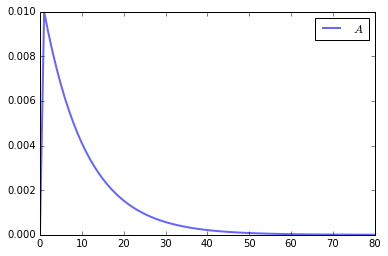

In [19]:
fig, plot_A = plt.subplots()
x = np.linspace(0, 80, 81)
plot_A.plot(x, rbc.irs['e_A']['A']/rbc.ss.A, linewidth=2, linestyle='solid', alpha=0.6, label='$A$')
plot_A.legend()
plt.savefig('plot_A.png')


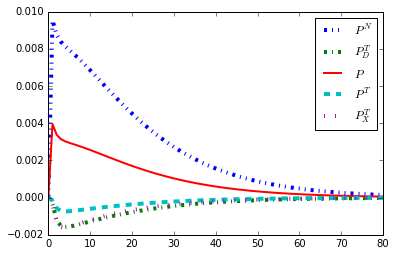

In [20]:
fig, PC_plot_P_GHH = plt.subplots()
PC_plot_P_GHH.plot(x, rbc.irs['e_A']['P_N']/rbc.ss.P_N, linewidth=4, linestyle=(0, (3, 5, 1, 5, 1, 5)), alpha=1, label='$P^N$')
PC_plot_P_GHH.plot(x, rbc.irs['e_A']['P_TD']/rbc.ss.P_TD, linewidth=4, linestyle='dashdot', alpha=1, label='$P^T_D$')
PC_plot_P_GHH.plot(x, rbc.irs['e_A']['P']/rbc.ss.P, linewidth=2, linestyle='solid', alpha=1, label='$P$')
PC_plot_P_GHH.plot(x, rbc.irs['e_A']['P_T']/rbc.ss.P_T, linewidth=4, linestyle='dashed', alpha=1, label='$P^T$')
PC_plot_P_GHH.plot(x, rbc.irs['e_A']['P_x']/rbc.ss.P_x, linewidth=4, linestyle=(0, (1, 10)), alpha=1, label='$P_X^T$')
PC_plot_P_GHH.legend(loc='upper right')
plt.savefig('PC_plot_P_GHH.png')

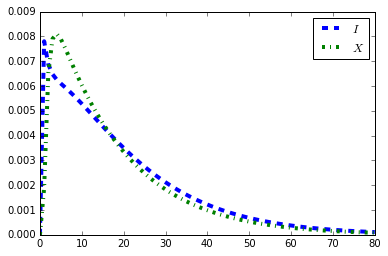

In [131]:
fig, PC_plot_NXIX_GHH = plt.subplots()
PC_plot_NXIX_GHH.plot(x, rbc.irs['e_A']['I']/rbc.ss.I, linewidth=4, linestyle='dashed', alpha=1, label='$I$')
PC_plot_NXIX_GHH.plot(x, rbc.irs['e_A']['X']/rbc.ss.X, linewidth=4, linestyle='dashdot', alpha=1, label='$X$')
PC_plot_NXIX_GHH.legend()
plt.savefig('PC_plot_NXIX_GHH.png')

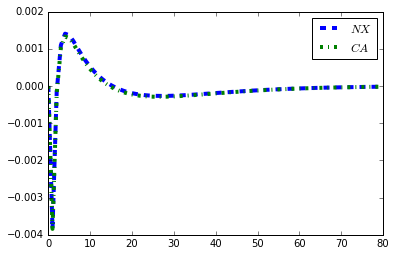

In [19]:
fig, PC_plot_check = plt.subplots()
PC_plot_check.plot(x, rbc.irs['e_A']['NX'], linewidth=4, linestyle='dashed', alpha=1, label='$NX$')
PC_plot_check.plot(x, rbc.irs['e_A']['CA'], linewidth=4, linestyle='dashdot', alpha=1, label='$CA$')
PC_plot_check.legend()

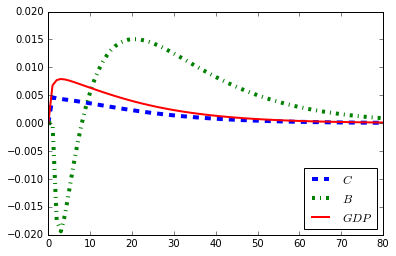

In [132]:
fig, PC_plot_macro_GHH = plt.subplots()
PC_plot_macro_GHH.plot(x, rbc.irs['e_A']['C']/rbc.ss.C, linewidth=4, linestyle='dashed', alpha=1, label='$C$')
PC_plot_macro_GHH.plot(x, rbc.irs['e_A']['B']/rbc.ss.B, linewidth=4, linestyle='dashdot', alpha=1, label='$B$')
PC_plot_macro_GHH.plot(x, rbc.irs['e_A']['GDP']/rbc.ss.GDP, linewidth=2, linestyle='solid', alpha=1, label='$GDP$')
PC_plot_macro_GHH.legend(loc='lower right')
plt.savefig('PC_plot_macro_GHH.png')

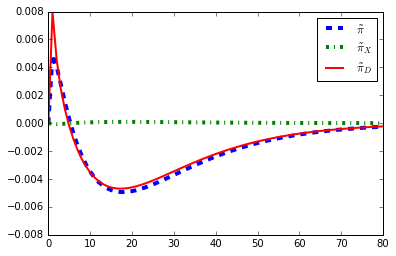

In [17]:
fig, PC_plot_d_GHH = plt.subplots()
PC_plot_d_GHH.plot(x, rbc.irs['e_A']['d_tilde']/rbc.ss.d_tilde, linewidth=4, linestyle='dashed', alpha=1, label=r'$\tilde{\pi}$')
PC_plot_d_GHH.plot(x, rbc.irs['e_A']['d_tilde_x']/rbc.ss.d_tilde_x, linewidth=4, linestyle='dashdot', alpha=1, label=r'$\tilde{\pi}_X$')
PC_plot_d_GHH.plot(x, rbc.irs['e_A']['d_tilde_d']/rbc.ss.d_tilde_d, linewidth=2, linestyle='solid', alpha=1, label=r'$\tilde{\pi}_D$')
PC_plot_d_GHH.legend(loc='upper right')
axes = plt.gca()
axes.set_ylim([-0.008,0.008])
plt.savefig('PC_plot_d_GHH.png')

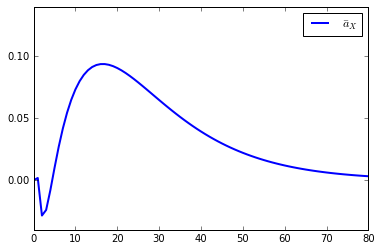

In [21]:
fig, plot_abar = plt.subplots()
plot_abar.plot(x, rbc.irs['e_A']['a_bar_x'], linewidth=2, linestyle='solid', alpha=1, label=r'$\bar{a}_X$')
plot_abar.legend()
axes = plt.gca()
axes.set_ylim([-0.04,0.14])
plt.savefig('plot_abar.png')

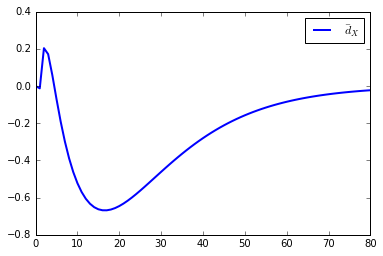

In [21]:
fig, plot_dbar = plt.subplots()
plot_dbar.plot(x, rbc.irs['e_A']['d_bar_x'], linewidth=2, linestyle='solid', alpha=1, label=r'$\bar{d}_X$')
plot_dbar.legend()
plt.savefig('plot_dbar.png')

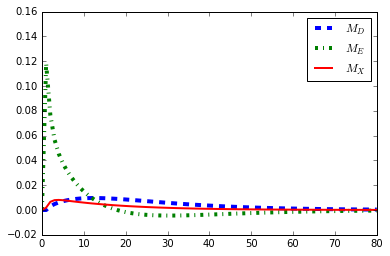

In [18]:
fig, PC_plot_M_GHH = plt.subplots()
PC_plot_M_GHH.plot(x, rbc.irs['e_A']['M_d']/rbc.ss.M_d, linewidth=4, linestyle='dashed', alpha=1, label=r'$M_D$')
PC_plot_M_GHH.plot(x, rbc.irs['e_A']['M_e']/rbc.ss.M_e, linewidth=4, linestyle='dashdot', alpha=1, label=r'$M_E$')
PC_plot_M_GHH.plot(x, rbc.irs['e_A']['M_x']/rbc.ss.M_x, linewidth=2, linestyle='solid', alpha=1, label=r'$M_X$')
PC_plot_M_GHH.legend()
axes = plt.gca()
axes.set_ylim([-0.02,0.16])
plt.savefig('PC_plot_M_GHH.png')

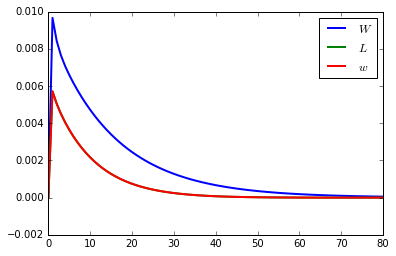

In [23]:
fig, PC_plot_W_GHH = plt.subplots()
PC_plot_W_GHH.plot(x, rbc.irs['e_A']['W']/rbc.ss.W, linewidth=2, linestyle='solid', alpha=1, label=r'$W$')
PC_plot_W_GHH.plot(x, rbc.irs['e_A']['L']/rbc.ss.L, linewidth=2, linestyle='solid', alpha=1, label=r'$L$')
PC_plot_W_GHH.plot(x, rbc.irs['e_A']['w']/rbc.ss.w, linewidth=2, linestyle='solid', alpha=1, label=r'$w$')
PC_plot_W_GHH.legend()
plt.savefig('PC_plot_W_GHH.png')


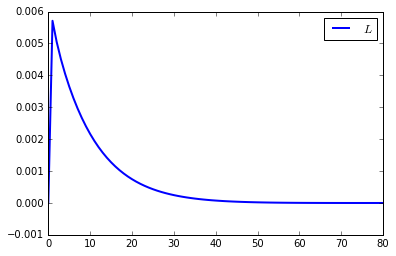

In [213]:
fig, PC_plot_L_GHH = plt.subplots()
PC_plot_L_GHH.plot(x, rbc.irs['e_A']['L']/rbc.ss.L, linewidth=2, linestyle='solid', alpha=1, label=r'$L$')
PC_plot_L_GHH.legend()
plt.savefig('PC_plot_L_GHH.png')

In [28]:
df_EC_Llambda = pd.read_csv (r'PC_GHH_EC_Llambda.csv', header=0)
df_EC_Hlambda = pd.read_csv (r'PC_GHH_EC_Hlambda.csv', header=0)
df_EC_2 = pd.read_csv (r'PC_GHH_EC2.csv', header=0)
df_EC_3 = pd.read_csv (r'PC_GHH_EC3.csv', header=0)

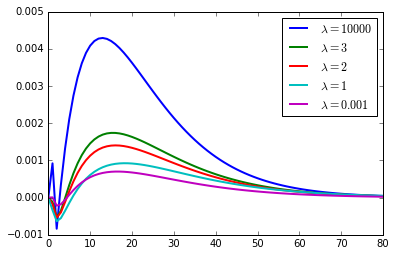

In [34]:
fig, PC_plot_EC_GHH = plt.subplots()
PC_plot_EC_GHH.plot(x, df_EC_Llambda, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=10000$')
PC_plot_EC_GHH.plot(x, df_EC_3, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=3$')
PC_plot_EC_GHH.plot(x, df_EC_2, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=2$')
PC_plot_EC_GHH.plot(x, rbc.irs['e_A']['EC']/rbc.ss.EC, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=1$')
PC_plot_EC_GHH.plot(x, df_EC_Hlambda, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=0.001$')
PC_plot_EC_GHH.legend(loc='upper right')
plt.savefig('PC_plot_EC_GHH.png')


In [21]:
df = pd.read_csv (r'GDP_exprof_GHH_const.csv', header=0)
    
df_EM=pd.read_csv (r'EM_GHH_const.csv', header=0)
df_IM=pd.read_csv (r'GDP_IM_GHH_const.csv', header=0)
df_SE=pd.read_csv (r'GDP_SE_GHH_const.csv', header=0)

In [22]:
PC_df = pd.read_csv (r'PC_exprof_GHH_const.csv', header=0)
    
PC_df_EM=pd.read_csv (r'PC_EM_GHH_const.csv', header=0)
PC_df_IM=pd.read_csv (r'PC_IM_GHH_const.csv', header=0)
PC_df_SE=pd.read_csv (r'PC_SE_GHH_const.csv', header=0)

In [57]:
df_EM_Llambda=pd.read_csv (r'EM_GHH_Llambda.csv', header=0)
df_EM_Hlambda=pd.read_csv (r'EM_GHH_Hlambda.csv', header=0)
df_EM_Llambda_const=pd.read_csv (r'EM_GHH_Llambda_const.csv', header=0)
df_EM_Hlambda_const=pd.read_csv (r'EM_GHH_Hlambda_const.csv', header=0)
df_EM_2=pd.read_csv (r'EM_GHH2.csv', header=0)
df_EM_3=pd.read_csv (r'EM_GHH3.csv', header=0)
df_EM_2_const=pd.read_csv (r'EM_GHH2_const.csv', header=0)
df_EM_3_const=pd.read_csv (r'EM_GHH3_const.csv', header=0)


df_SE_Llambda=pd.read_csv (r'GDP_SE_GHH_Llambda.csv', header=0)
df_SE_Hlambda=pd.read_csv (r'GDP_SE_GHH_Hlambda.csv', header=0)
df_SE_Llambda_const=pd.read_csv (r'GDP_SE_GHH_Llambda_const.csv', header=0)
df_SE_Hlambda_const=pd.read_csv (r'GDP_SE_GHH_Hlambda_const.csv', header=0)
df_SE_2=pd.read_csv (r'GDP_SE_GHH2.csv', header=0)
df_SE_3=pd.read_csv (r'GDP_SE_GHH3.csv', header=0)
df_SE_2_const=pd.read_csv (r'GDP_SE_GHH2_const.csv', header=0)
df_SE_3_const=pd.read_csv (r'GDP_SE_GHH3_const.csv', header=0)


df_exprof_Llambda=pd.read_csv (r'GDP_exprof_GHH_Llambda.csv', header=0)
df_exprof_Hlambda=pd.read_csv (r'GDP_exprof_GHH_Hlambda.csv', header=0)
df_exprof_Llambda_const=pd.read_csv (r'GDP_exprof_GHH_Llambda_const.csv', header=0)
df_exprof_Hlambda_const=pd.read_csv (r'GDP_exprof_GHH_Hlambda_const.csv', header=0)
df_exprof_2=pd.read_csv (r'GDP_exprof_GHH2.csv', header=0)
df_exprof_3=pd.read_csv (r'GDP_exprof_GHH3.csv', header=0)
df_exprof_2_const=pd.read_csv (r'GDP_exprof_GHH2_const.csv', header=0)
df_exprof_3_const=pd.read_csv (r'GDP_exprof_GHH3_const.csv', header=0)

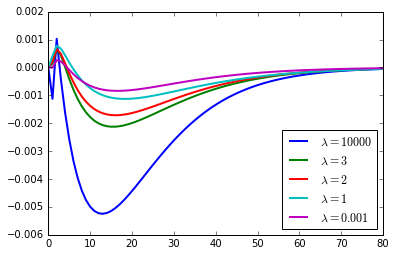

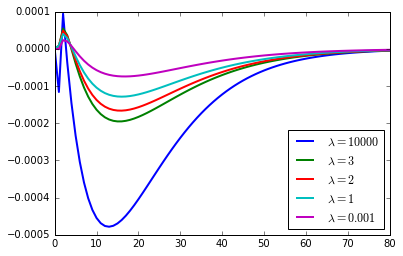

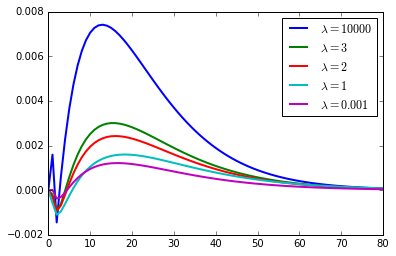

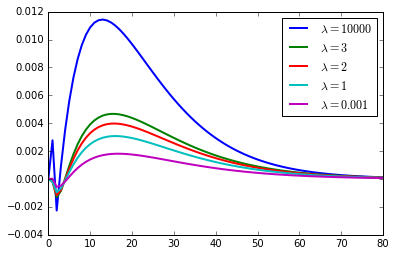

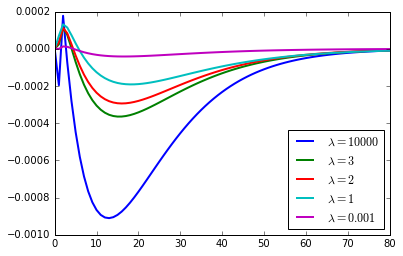

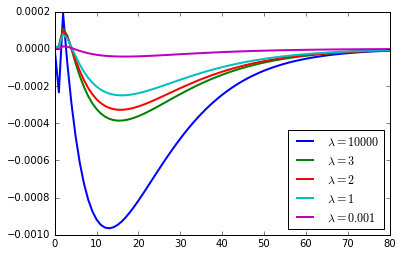

In [35]:
fig, plot_EM_GHH_lambdas = plt.subplots()
plot_EM_GHH_lambdas.plot(x, df_EM_Llambda, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=10000$')
plot_EM_GHH_lambdas.plot(x, df_EM_3, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=3$')
plot_EM_GHH_lambdas.plot(x, df_EM_2, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=2$')
plot_EM_GHH_lambdas.plot(x, rbc.irs['e_A']['EM'], linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=1$')
plot_EM_GHH_lambdas.plot(x, df_EM_Hlambda, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=0.001$')
plot_EM_GHH_lambdas.legend(loc='lower right')
plt.savefig('plot_EM_GHH_lambdas.png')

fig, plot_EM_GHH_lambdas_const = plt.subplots()
plot_EM_GHH_lambdas_const.plot(x, df_EM_Llambda_const, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=10000$')
plot_EM_GHH_lambdas_const.plot(x, df_EM_3_const, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=3$')
plot_EM_GHH_lambdas_const.plot(x, df_EM_2_const, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=2$')
plot_EM_GHH_lambdas_const.plot(x, df_EM, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=1$')
plot_EM_GHH_lambdas_const.plot(x, df_EM_Hlambda_const, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=0.001$')
plot_EM_GHH_lambdas_const.legend(loc='lower right')
plt.savefig('plot_EM_GHH_lambdas_const.png')

fig, plot_SE_GHH_lambdas = plt.subplots()
plot_SE_GHH_lambdas.plot(x, df_SE_Llambda, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=10000$')
plot_SE_GHH_lambdas.plot(x, df_SE_3, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=3$')
plot_SE_GHH_lambdas.plot(x, df_SE_2, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=2$')
plot_SE_GHH_lambdas.plot(x, rbc.irs['e_A']['a_tilde_x']/1.217, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=1$')
plot_SE_GHH_lambdas.plot(x, df_SE_Hlambda, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=0.001$')
plot_SE_GHH_lambdas.legend(loc='upper right')
plt.savefig('plot_SE_GHH_lambdas.png')

fig, plot_SE_GHH_lambdas_const = plt.subplots()
plot_SE_GHH_lambdas_const.plot(x, df_SE_Llambda_const, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=10000$')
plot_SE_GHH_lambdas_const.plot(x, df_SE_3_const, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=3$')
plot_SE_GHH_lambdas_const.plot(x, df_SE_2_const, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=2$')
plot_SE_GHH_lambdas_const.plot(x, df_SE, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=1$')
plot_SE_GHH_lambdas_const.plot(x, df_SE_Hlambda_const, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=0.001$')
plot_SE_GHH_lambdas_const.legend()
plt.savefig('plot_SE_GHH_lambdas_const.png')

fig, plot_exprof_GHH_lambdas = plt.subplots()
plot_exprof_GHH_lambdas.plot(x, df_exprof_Llambda, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=10000$')
plot_exprof_GHH_lambdas.plot(x, df_exprof_3, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=3$')
plot_exprof_GHH_lambdas.plot(x, df_exprof_2, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=2$')
plot_exprof_GHH_lambdas.plot(x, rbc.irs['e_A']['exprof']/rbc.ss.GDP, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=1$')
plot_exprof_GHH_lambdas.plot(x, df_exprof_Hlambda, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=0.001$')
plot_exprof_GHH_lambdas.legend(loc='lower right')
plt.savefig('plot_exprof_GHH_lambdas.png')

fig, plot_exprof_GHH_lambdas_const = plt.subplots()
plot_exprof_GHH_lambdas_const.plot(x, df_exprof_Llambda_const, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=10000$')
plot_exprof_GHH_lambdas_const.plot(x, df_exprof_3_const, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=3$')
plot_exprof_GHH_lambdas_const.plot(x, df_exprof_2_const, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=2$')
plot_exprof_GHH_lambdas_const.plot(x, df, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=1$')
plot_exprof_GHH_lambdas_const.plot(x, df_exprof_Hlambda_const, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=0.001$')
plot_exprof_GHH_lambdas_const.legend(loc='lower right')
plt.savefig('plot_exprof_GHH_lambdas_const.png')

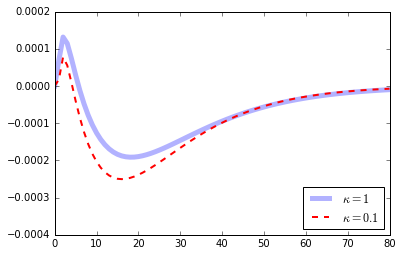

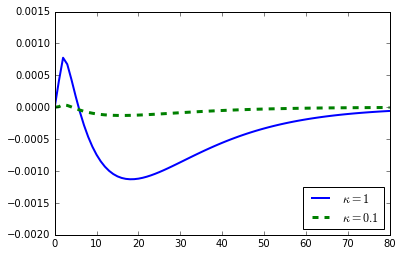

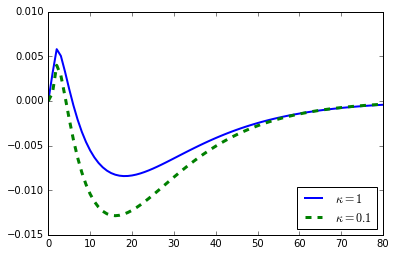

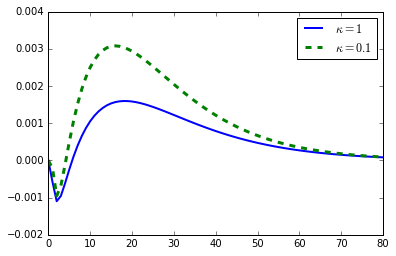

In [24]:
## 
fig, GDP_plot_exprof_GHH = plt.subplots()
x = np.linspace(0, 80, 81)
GDP_plot_exprof_GHH.plot(x, rbc.irs['e_A']['exprof']/rbc.ss.GDP, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
GDP_plot_exprof_GHH.plot(x, df, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
GDP_plot_exprof_GHH.legend(loc='lower right')
axes = plt.gca()
axes.set_ylim([-0.0004,0.0002])
plt.savefig('GDP_plot_exprof_GHH.png')

fig, plot_EM_GHH = plt.subplots()
x = np.linspace(0, 80, 81)
plot_EM_GHH.plot(x, rbc.irs['e_A']['EM'], linewidth=2, linestyle='solid', alpha=1, label=r'$\kappa=1$')
plot_EM_GHH.plot(x, df_EM, linewidth=3, linestyle='dashed', alpha=1, label=r'$\kappa=0.1$')
plot_EM_GHH.legend(loc='lower right')
axes = plt.gca()
axes.set_ylim([-0.002,0.0015])
plt.savefig('plot_EM_GHH.png')

fig, GDP_plot_IM_GHH = plt.subplots()
x = np.linspace(0, 80, 81)
GDP_plot_IM_GHH.plot(x, rbc.irs['e_A']['d_bar_x']/rbc.ss.GDP, linewidth=2, linestyle='solid', alpha=1, label=r'$\kappa=1$')
GDP_plot_IM_GHH.plot(x, df_IM, linewidth=3, linestyle='dashed', alpha=1, label=r'$\kappa=0.1$')
GDP_plot_IM_GHH.legend(loc='lower right')
plt.savefig('GDP_plot_IM_GHH.png')

fig, GDP_plot_SE_GHH = plt.subplots()
x = np.linspace(0, 80, 81)
GDP_plot_SE_GHH.plot(x, rbc.irs['e_A']['a_tilde_x']/1.217, linewidth=2, linestyle='solid', alpha=1, label=r'$\kappa=1$')
GDP_plot_SE_GHH.plot(x, df_SE, linewidth=3, linestyle='dashed', alpha=1, label=r'$\kappa=0.1$')
GDP_plot_SE_GHH.legend()
plt.savefig('GDP_plot_SE_GHH.png')

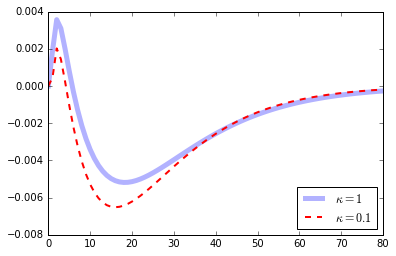

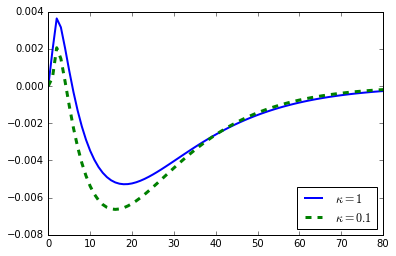

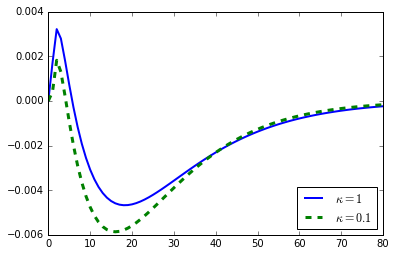

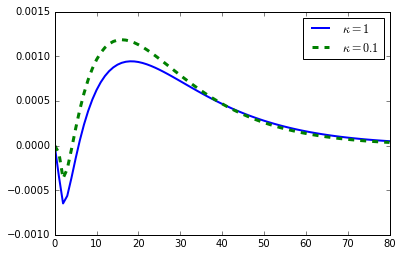

In [218]:
fig, PC_plot_exprof_GHH = plt.subplots()
x = np.linspace(0, 80, 81)
PC_plot_exprof_GHH.plot(x, rbc.irs['e_A']['exprof']/rbc.ss.exprof, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
PC_plot_exprof_GHH.plot(x, PC_df, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
PC_plot_exprof_GHH.legend(loc='lower right')
plt.savefig('PC_plot_exprof_GHH.png')

fig, PC_plot_EM_GHH = plt.subplots()
x = np.linspace(0, 80, 81)
PC_plot_EM_GHH.plot(x, rbc.irs['e_A']['EM']/rbc.ss.EM, linewidth=2, linestyle='solid', alpha=1, label=r'$\kappa=1$')
PC_plot_EM_GHH.plot(x, PC_df_EM, linewidth=3, linestyle='dashed', alpha=1, label=r'$\kappa=0.1$')
PC_plot_EM_GHH.legend(loc='lower right')
plt.savefig('PC_plot_EM_GHH.png')

fig, PC_plot_IM_GHH = plt.subplots()
x = np.linspace(0, 80, 81)
PC_plot_IM_GHH.plot(x, rbc.irs['e_A']['d_bar_x']/rbc.ss.d_bar_x, linewidth=2, linestyle='solid', alpha=1, label=r'$\kappa=1$')
PC_plot_IM_GHH.plot(x, PC_df_IM, linewidth=3, linestyle='dashed', alpha=1, label=r'$\kappa=0.1$')
PC_plot_IM_GHH.legend(loc='lower right')
plt.savefig('PC_plot_IM_GHH.png')

fig, PC_plot_SE_GHH = plt.subplots()
x = np.linspace(0, 80, 81)
PC_plot_SE_GHH.plot(x, rbc.irs['e_A']['a_tilde_x']/rbc.ss.a_tilde_x, linewidth=2, linestyle='solid', alpha=1, label=r'$\kappa=1$')
PC_plot_SE_GHH.plot(x, PC_df_SE, linewidth=3, linestyle='dashed', alpha=1, label=r'$\kappa=0.1$')
PC_plot_SE_GHH.legend()
plt.savefig('PC_plot_SE_GHH.png')

In [219]:
df_P_x=pd.read_csv (r'PC_P_x_GHH_const.csv', header=0)
df_X=pd.read_csv (r'PC_X_GHH_const.csv', header=0)
df_GDP=pd.read_csv (r'PC_GDP_GHH_const.csv', header=0)
df_M_d=pd.read_csv (r'PC_M_d_GHH_const.csv', header=0)
df_d_tilde=pd.read_csv (r'PC_d_tilde_GHH_const.csv', header=0)
df_W=pd.read_csv (r'PC_W_GHH_const.csv', header=0)

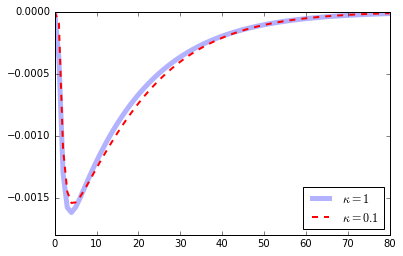

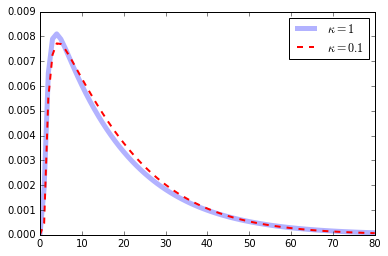

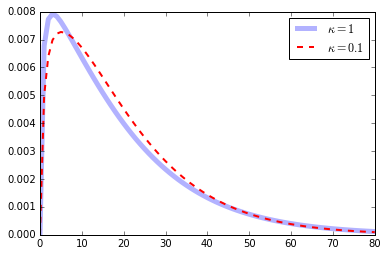

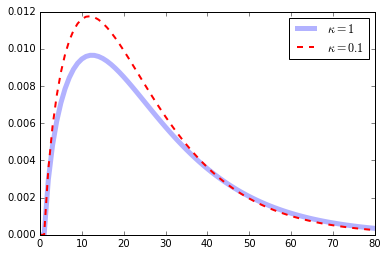

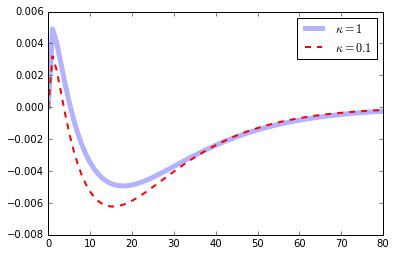

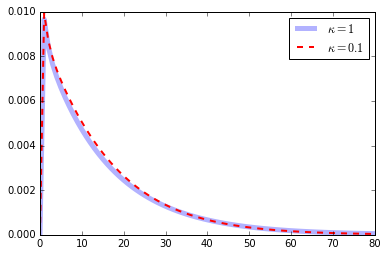

In [221]:
fig, PC_plot_P_x_GHH = plt.subplots()
x = np.linspace(0, 80, 81)
PC_plot_P_x_GHH.plot(x, rbc.irs['e_A']['P_x']/rbc.ss.P_x, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
PC_plot_P_x_GHH.plot(x, df_P_x, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
PC_plot_P_x_GHH.legend(loc='lower right')
plt.savefig('PC_plot_P_x_GHH.png')

fig, PC_plot_X_GHH = plt.subplots()
x = np.linspace(0, 80, 81)
PC_plot_X_GHH.plot(x, rbc.irs['e_A']['X']/rbc.ss.X, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
PC_plot_X_GHH.plot(x, df_X, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
PC_plot_X_GHH.legend()
plt.savefig('PC_plot_X_GHH.png')

fig, PC_plot_GDP_GHH = plt.subplots()
x = np.linspace(0, 80, 81)
PC_plot_GDP_GHH.plot(x, rbc.irs['e_A']['GDP']/rbc.ss.GDP, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
PC_plot_GDP_GHH.plot(x, df_GDP, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
PC_plot_GDP_GHH.legend()
plt.savefig('PC_plot_GDP_GHH.png')

fig, PC_plot_M_d_GHH = plt.subplots()
x = np.linspace(0, 80, 81)
PC_plot_M_d_GHH.plot(x, rbc.irs['e_A']['M_d']/rbc.ss.M_d, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
PC_plot_M_d_GHH.plot(x, df_M_d, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
PC_plot_M_d_GHH.legend()
plt.savefig('PC_plot_M_d_GHH.png')

fig, PC_plot_d_tilde_GHH = plt.subplots()
x = np.linspace(0, 80, 81)
PC_plot_d_tilde_GHH.plot(x, rbc.irs['e_A']['d_tilde']/rbc.ss.d_tilde, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
PC_plot_d_tilde_GHH.plot(x, df_d_tilde, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
PC_plot_d_tilde_GHH.legend()
plt.savefig('PC_plot_d_tilde_GHH.png')

fig, PC_plot_Wage_GHH = plt.subplots()
x = np.linspace(0, 80, 81)
PC_plot_Wage_GHH.plot(x, rbc.irs['e_A']['W']/rbc.ss.W, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
PC_plot_Wage_GHH.plot(x, df_W, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
PC_plot_Wage_GHH.legend()
plt.savefig('PC_plot_Wage_GHH.png')

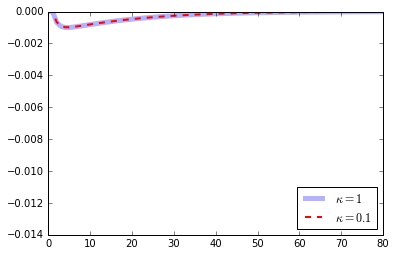

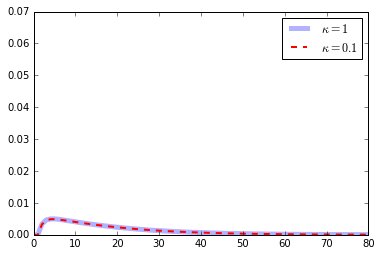

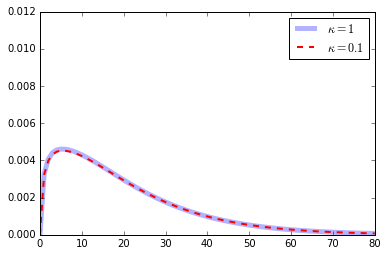

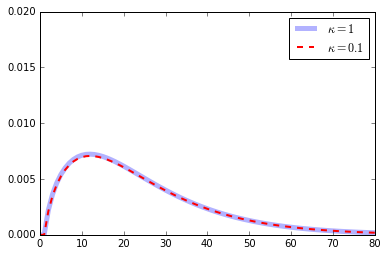

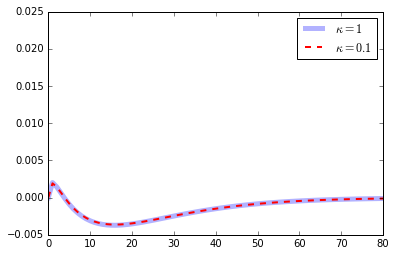

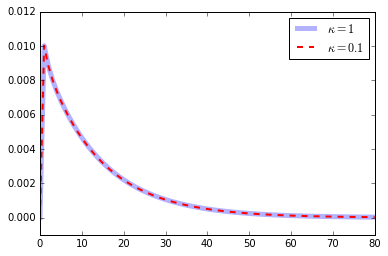

In [47]:
fig, PC_fixW_plot_P_x = plt.subplots()
x = np.linspace(0, 80, 81)
PC_fixW_plot_P_x.plot(x, rbc.irs['e_A']['P_x']/rbc.ss.P_x, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
PC_fixW_plot_P_x.plot(x, df_P_x, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
PC_fixW_plot_P_x.legend(loc='lower right')
axes = plt.gca()
axes.set_ylim([-0.014,0])
plt.savefig('PC_fixW_plot_P_x.png')

fig, PC_fixW_plot_X = plt.subplots()
x = np.linspace(0, 80, 81)
PC_fixW_plot_X.plot(x, rbc.irs['e_A']['X']/rbc.ss.X, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
PC_fixW_plot_X.plot(x, df_X, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
PC_fixW_plot_X.legend()
axes = plt.gca()
axes.set_ylim([0,0.07])
plt.savefig('PC_fixW_plot_X.png')

fig, PC_fixW_plot_GDP = plt.subplots()
x = np.linspace(0, 80, 81)
PC_fixW_plot_GDP.plot(x, rbc.irs['e_A']['GDP']/rbc.ss.GDP, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
PC_fixW_plot_GDP.plot(x, df_GDP, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
PC_fixW_plot_GDP.legend()
axes = plt.gca()
axes.set_ylim([0,0.012])
plt.savefig('PC_fixW_plot_GDP.png')

fig, PC_fixW_plot_M_d = plt.subplots()
x = np.linspace(0, 80, 81)
PC_fixW_plot_M_d.plot(x, rbc.irs['e_A']['M_d']/rbc.ss.M_d, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
PC_fixW_plot_M_d.plot(x, df_M_d, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
PC_fixW_plot_M_d.legend()
axes = plt.gca()
axes.set_ylim([0,0.02])
plt.savefig('PC_fixW_plot_M_d.png')

fig, PC_fixW_plot_d_tilde = plt.subplots()
x = np.linspace(0, 80, 81)
PC_fixW_plot_d_tilde.plot(x, rbc.irs['e_A']['d_tilde']/rbc.ss.d_tilde, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
PC_fixW_plot_d_tilde.plot(x, df_d_tilde, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
PC_fixW_plot_d_tilde.legend()
axes = plt.gca()
axes.set_ylim([-0.005,0.025])
plt.savefig('PC_fixW_plot_d_tilde.png')

fig, PC_fixW_plot_Wage = plt.subplots()
x = np.linspace(0, 80, 81)
PC_fixW_plot_Wage.plot(x, rbc.irs['e_A']['W']/rbc.ss.W, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
PC_fixW_plot_Wage.plot(x, df_W, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
PC_fixW_plot_Wage.legend()
axes = plt.gca()
axes.set_ylim([-0.001,0.012])
plt.savefig('PC_fixW_plot_Wage.png')

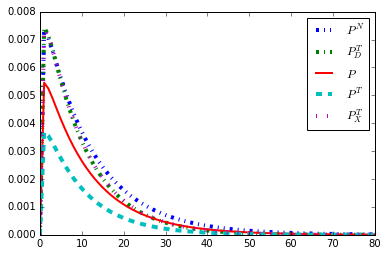

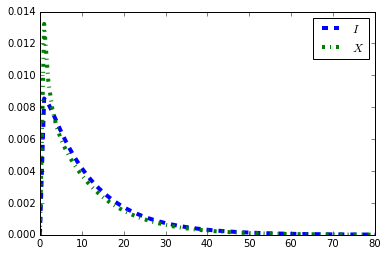

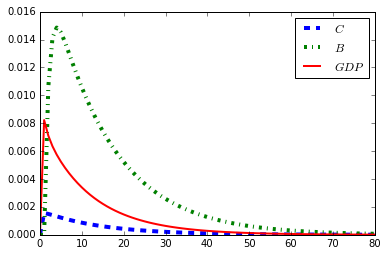

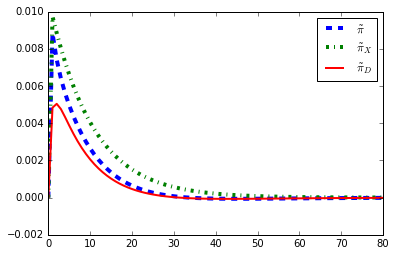

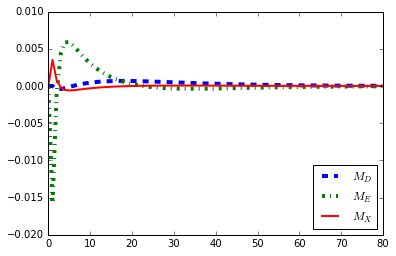

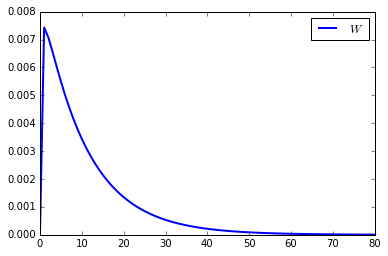

In [17]:
fig, Pstar_PC_plot_P = plt.subplots()
Pstar_PC_plot_P.plot(x, rbc.irs['e_P_star']['P_N']/rbc.ss.P_N, linewidth=4, linestyle=(0, (3, 5, 1, 5, 1, 5)), alpha=1, label='$P^N$')
Pstar_PC_plot_P.plot(x, rbc.irs['e_P_star']['P_TD']/rbc.ss.P_TD, linewidth=4, linestyle='dashdot', alpha=1, label='$P^T_D$')
Pstar_PC_plot_P.plot(x, rbc.irs['e_P_star']['P']/rbc.ss.P, linewidth=2, linestyle='solid', alpha=1, label='$P$')
Pstar_PC_plot_P.plot(x, rbc.irs['e_P_star']['P_T']/rbc.ss.P_T, linewidth=4, linestyle='dashed', alpha=1, label='$P^T$')
Pstar_PC_plot_P.plot(x, rbc.irs['e_P_star']['P_x']/rbc.ss.P_x, linewidth=4, linestyle=(0, (1, 10)), alpha=1, label='$P_X^T$')
Pstar_PC_plot_P.legend(loc='upper right')
plt.savefig('Pstar_PC_plot_P.png')

fig, Pstar_PC_plot_NXIX = plt.subplots()
Pstar_PC_plot_NXIX.plot(x, rbc.irs['e_P_star']['I']/rbc.ss.I, linewidth=4, linestyle='dashed', alpha=1, label='$I$')
Pstar_PC_plot_NXIX.plot(x, rbc.irs['e_P_star']['X']/rbc.ss.X, linewidth=4, linestyle='dashdot', alpha=1, label='$X$')
Pstar_PC_plot_NXIX.legend()
plt.savefig('Pstar_PC_plot_NXIX.png')

fig, Pstar_PC_plot_macro = plt.subplots()
Pstar_PC_plot_macro.plot(x, rbc.irs['e_P_star']['C']/rbc.ss.C, linewidth=4, linestyle='dashed', alpha=1, label='$C$')
Pstar_PC_plot_macro.plot(x, rbc.irs['e_P_star']['B']/rbc.ss.B, linewidth=4, linestyle='dashdot', alpha=1, label='$B$')
Pstar_PC_plot_macro.plot(x, rbc.irs['e_P_star']['GDP']/rbc.ss.GDP, linewidth=2, linestyle='solid', alpha=1, label='$GDP$')
Pstar_PC_plot_macro.legend(loc='upper right')
plt.savefig('Pstar_PC_plot_macro.png')

fig, Pstar_PC_plot_d = plt.subplots()
Pstar_PC_plot_d.plot(x, rbc.irs['e_P_star']['d_tilde']/rbc.ss.d_tilde, linewidth=4, linestyle='dashed', alpha=1, label=r'$\tilde{\pi}$')
Pstar_PC_plot_d.plot(x, rbc.irs['e_P_star']['d_tilde_x']/rbc.ss.d_tilde_x, linewidth=4, linestyle='dashdot', alpha=1, label=r'$\tilde{\pi}_X$')
Pstar_PC_plot_d.plot(x, rbc.irs['e_P_star']['d_tilde_d']/rbc.ss.d_tilde_d, linewidth=2, linestyle='solid', alpha=1, label=r'$\tilde{\pi}_D$')
Pstar_PC_plot_d.legend(loc='upper right')
plt.savefig('Pstar_PC_plot_d.png')

fig, Pstar_PC_plot_M = plt.subplots()
Pstar_PC_plot_M.plot(x, rbc.irs['e_P_star']['M_d']/rbc.ss.M_d, linewidth=4, linestyle='dashed', alpha=1, label=r'$M_D$')
Pstar_PC_plot_M.plot(x, rbc.irs['e_P_star']['M_e']/rbc.ss.M_e, linewidth=4, linestyle='dashdot', alpha=1, label=r'$M_E$')
Pstar_PC_plot_M.plot(x, rbc.irs['e_P_star']['M_x']/rbc.ss.M_x, linewidth=2, linestyle='solid', alpha=1, label=r'$M_X$')
Pstar_PC_plot_M.legend(loc='lower right')
plt.savefig('Pstar_PC_plot_M.png')

fig, Pstar_PC_plot_W = plt.subplots()
Pstar_PC_plot_W.plot(x, rbc.irs['e_P_star']['W']/rbc.ss.W, linewidth=2, linestyle='solid', alpha=1, label=r'$W$')
Pstar_PC_plot_W.legend()
plt.savefig('Pstar_PC_plot_W.png')


In [18]:
df = pd.read_csv (r'Pstar_GDP_exprof_const.csv', header=0)
    
df_EM=pd.read_csv (r'Pstar_EM_const.csv', header=0)
df_IM=pd.read_csv (r'Pstar_GDP_IM_const.csv', header=0)
df_SE=pd.read_csv (r'Pstar_GDP_SE_const.csv', header=0)

In [19]:
PC_df = pd.read_csv (r'Pstar_PC_exprof_const.csv', header=0)
    
PC_df_EM=pd.read_csv (r'Pstar_PC_EM_const.csv', header=0)
PC_df_IM=pd.read_csv (r'Pstar_PC_IM_const.csv', header=0)
PC_df_SE=pd.read_csv (r'Pstar_PC_SE_const.csv', header=0)

In [20]:
df_P_x=pd.read_csv (r'Pstar_PC_P_x_const.csv', header=0)
df_X=pd.read_csv (r'Pstar_PC_X_const.csv', header=0)
df_GDP=pd.read_csv (r'Pstar_PC_GDP_const.csv', header=0)
df_M_d=pd.read_csv (r'Pstar_PC_M_d_const.csv', header=0)
df_d_tilde=pd.read_csv (r'Pstar_PC_d_tilde_const.csv', header=0)
df_W=pd.read_csv (r'Pstar_PC_W_const.csv', header=0)

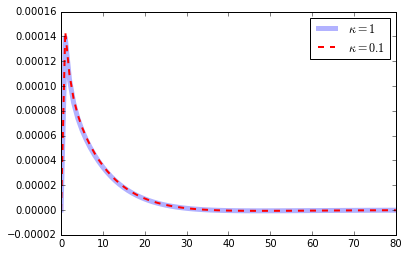

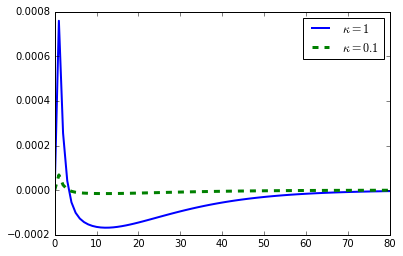

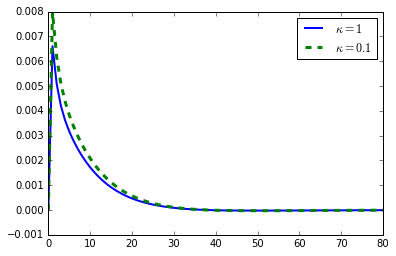

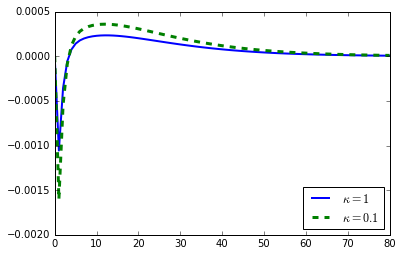

In [21]:
fig, Pstar_GDP_plot_exprof = plt.subplots()
x = np.linspace(0, 80, 81)
Pstar_GDP_plot_exprof.plot(x, rbc.irs['e_P_star']['exprof']/rbc.ss.GDP, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
Pstar_GDP_plot_exprof.plot(x, df, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
Pstar_GDP_plot_exprof.legend(loc='upper right')
plt.savefig('Pstar_GDP_plot_exprof.png')

fig, Pstar_plot_EM = plt.subplots()
x = np.linspace(0, 80, 81)
Pstar_plot_EM.plot(x, rbc.irs['e_P_star']['EM'], linewidth=2, linestyle='solid', alpha=1, label=r'$\kappa=1$')
Pstar_plot_EM.plot(x, df_EM, linewidth=3, linestyle='dashed', alpha=1, label=r'$\kappa=0.1$')
Pstar_plot_EM.legend(loc='upper right')
plt.savefig('Pstar_plot_EM.png')

fig, Pstar_GDP_plot_IM = plt.subplots()
x = np.linspace(0, 80, 81)
Pstar_GDP_plot_IM.plot(x, rbc.irs['e_P_star']['d_bar_x']/rbc.ss.GDP, linewidth=2, linestyle='solid', alpha=1, label=r'$\kappa=1$')
Pstar_GDP_plot_IM.plot(x, df_IM, linewidth=3, linestyle='dashed', alpha=1, label=r'$\kappa=0.1$')
Pstar_GDP_plot_IM.legend(loc='upper right')
plt.savefig('Pstar_GDP_plot_IM.png')

fig, Pstar_GDP_plot_SE = plt.subplots()
x = np.linspace(0, 80, 81)
Pstar_GDP_plot_SE.plot(x, rbc.irs['e_P_star']['a_tilde_x']/1.217, linewidth=2, linestyle='solid', alpha=1, label=r'$\kappa=1$')
Pstar_GDP_plot_SE.plot(x, df_SE, linewidth=3, linestyle='dashed', alpha=1, label=r'$\kappa=0.1$')
Pstar_GDP_plot_SE.legend(loc='lower right')
plt.savefig('Pstar_GDP_plot_SE.png')

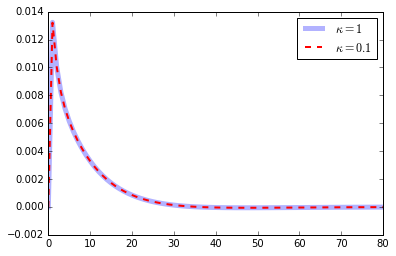

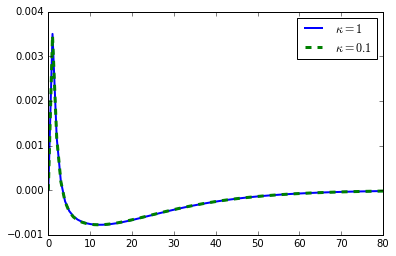

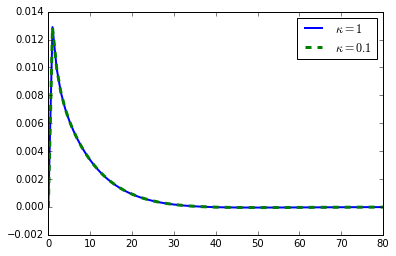

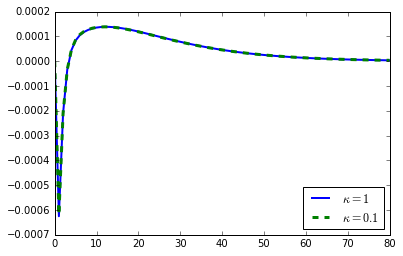

In [22]:
fig, Pstar_PC_plot_exprof = plt.subplots()
x = np.linspace(0, 80, 81)
Pstar_PC_plot_exprof.plot(x, rbc.irs['e_P_star']['exprof']/rbc.ss.exprof, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
Pstar_PC_plot_exprof.plot(x, PC_df, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
Pstar_PC_plot_exprof.legend(loc='upper right')
plt.savefig('Pstar_PC_plot_exprof.png')

fig, Pstar_PC_plot_EM = plt.subplots()
x = np.linspace(0, 80, 81)
Pstar_PC_plot_EM.plot(x, rbc.irs['e_P_star']['EM']/rbc.ss.EM, linewidth=2, linestyle='solid', alpha=1, label=r'$\kappa=1$')
Pstar_PC_plot_EM.plot(x, PC_df_EM, linewidth=3, linestyle='dashed', alpha=1, label=r'$\kappa=0.1$')
Pstar_PC_plot_EM.legend(loc='upper right')
plt.savefig('Pstar_PC_plot_EM.png')

fig, Pstar_PC_plot_IM = plt.subplots()
x = np.linspace(0, 80, 81)
Pstar_PC_plot_IM.plot(x, rbc.irs['e_P_star']['d_bar_x']/rbc.ss.d_bar_x, linewidth=2, linestyle='solid', alpha=1, label=r'$\kappa=1$')
Pstar_PC_plot_IM.plot(x, PC_df_IM, linewidth=3, linestyle='dashed', alpha=1, label=r'$\kappa=0.1$')
Pstar_PC_plot_IM.legend(loc='upper right')
plt.savefig('Pstar_PC_plot_IM.png')

fig, Pstar_PC_plot_SE = plt.subplots()
x = np.linspace(0, 80, 81)
Pstar_PC_plot_SE.plot(x, rbc.irs['e_P_star']['a_tilde_x']/rbc.ss.a_tilde_x, linewidth=2, linestyle='solid', alpha=1, label=r'$\kappa=1$')
Pstar_PC_plot_SE.plot(x, PC_df_SE, linewidth=3, linestyle='dashed', alpha=1, label=r'$\kappa=0.1$')
Pstar_PC_plot_SE.legend(loc='lower right')
plt.savefig('Pstar_PC_plot_SE.png')

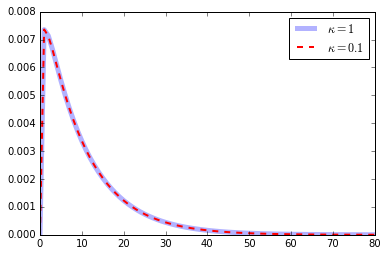

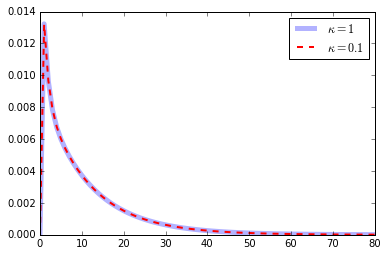

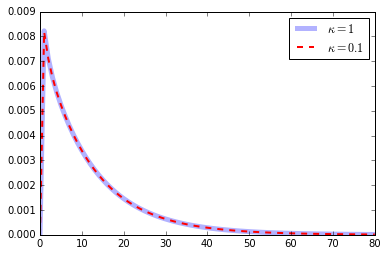

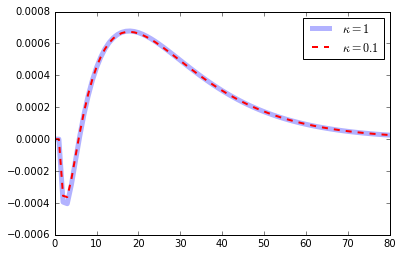

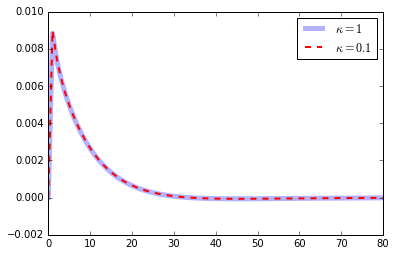

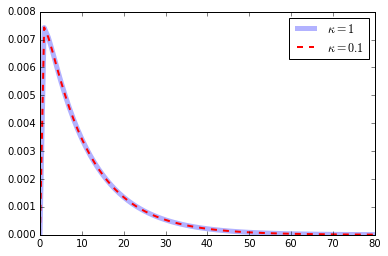

In [23]:
fig, Pstar_PC_plot_P_x = plt.subplots()
x = np.linspace(0, 80, 81)
Pstar_PC_plot_P_x.plot(x, rbc.irs['e_P_star']['P_x']/rbc.ss.P_x, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
Pstar_PC_plot_P_x.plot(x, df_P_x, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
Pstar_PC_plot_P_x.legend(loc='upper right')
plt.savefig('Pstar_PC_plot_P_x.png')

fig, Pstar_PC_plot_X = plt.subplots()
x = np.linspace(0, 80, 81)
Pstar_PC_plot_X.plot(x, rbc.irs['e_P_star']['X']/rbc.ss.X, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
Pstar_PC_plot_X.plot(x, df_X, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
Pstar_PC_plot_X.legend()
plt.savefig('Pstar_PC_plot_X.png')

fig, Pstar_PC_plot_GDP = plt.subplots()
x = np.linspace(0, 80, 81)
Pstar_PC_plot_GDP.plot(x, rbc.irs['e_P_star']['GDP']/rbc.ss.GDP, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
Pstar_PC_plot_GDP.plot(x, df_GDP, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
Pstar_PC_plot_GDP.legend()
plt.savefig('Pstar_PC_plot_GDP.png')

fig, Pstar_PC_plot_M_d = plt.subplots()
x = np.linspace(0, 80, 81)
Pstar_PC_plot_M_d.plot(x, rbc.irs['e_P_star']['M_d']/rbc.ss.M_d, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
Pstar_PC_plot_M_d.plot(x, df_M_d, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
Pstar_PC_plot_M_d.legend()
plt.savefig('Pstar_PC_plot_M_d.png')

fig, Pstar_PC_plot_d_tilde = plt.subplots()
x = np.linspace(0, 80, 81)
Pstar_PC_plot_d_tilde.plot(x, rbc.irs['e_P_star']['d_tilde']/rbc.ss.d_tilde, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
Pstar_PC_plot_d_tilde.plot(x, df_d_tilde, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
Pstar_PC_plot_d_tilde.legend()
plt.savefig('Pstar_PC_plot_d_tilde.png')

fig, Pstar_PC_plot_Wage = plt.subplots()
x = np.linspace(0, 80, 81)
Pstar_PC_plot_Wage.plot(x, rbc.irs['e_P_star']['W']/rbc.ss.W, linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
Pstar_PC_plot_Wage.plot(x, df_W, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
Pstar_PC_plot_Wage.legend()
plt.savefig('Pstar_PC_plot_Wage.png')

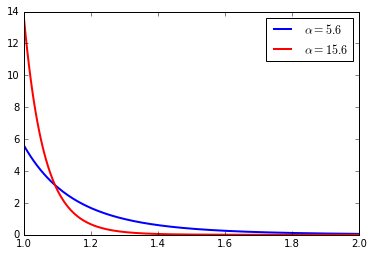

In [3]:
def G2(a):
    m=5.6*a**(-5.6-1)
    return m
    
def G3(a):
    m=13.6*a**(-15.6-1)
    return m
    
xx = np.linspace(1, 2, 200)
y2 = G2(xx)
y3= G3(xx)

fig, Pareto=plt.subplots()
Pareto.plot(xx, y2, 'b-', linewidth=2,label=r'$\alpha=5.6$')
Pareto.plot(xx, y3, 'r-', linewidth=2,label=r'$\alpha=15.6$')
Pareto.legend()
plt.savefig('Pareto')


In [43]:
def G2(a):
    m=5.6*a**(-5.6-1)
    return m
    
def G2(a):
    m=13.6*a**(-13.6-1)
    return m

In [45]:
x = np.linspace(1, 5, 200)

In [48]:
y2 = G2(x)
y3= G3(x)

NameError: name 'G3' is not defined